In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
# Define the custom mentee model
class MenteeModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load pre-trained ResNet18 model
resnet18 = models.resnet18(pretrained=True)

# Freeze the initial layers of ResNet18
for param in resnet18.parameters():
    param.requires_grad = False

# Modify the last fully connected layer of ResNet18 to match the number of classes
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 10)  # Assuming 10 classes for example

# Initialize the mentee model
mentee_model = MenteeModel()

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# Load datasets for training and validation
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define loss function and optimizer for mentor model
criterion_mentor = nn.CrossEntropyLoss()
optimizer_mentor = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

# Define loss function and optimizer for mentee model
criterion_mentee = nn.CrossEntropyLoss()
optimizer_mentee = optim.SGD(mentee_model.parameters(), lr=0.001, momentum=0.9)

# Initialize TensorBoard writer
writer = SummaryWriter()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss_mentor = 0.0
    running_loss_mentee = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer_mentor.zero_grad()
        optimizer_mentee.zero_grad()

        # Forward pass for mentor
        outputs_mentor = resnet18(inputs)
        loss_mentor = criterion_mentor(outputs_mentor, labels)

        # Forward pass for mentee
        outputs_mentee = mentee_model(inputs)
        loss_mentee = criterion_mentee(outputs_mentee, labels)

        # Knowledge distillation loss
        temperature = 5
        soft_outputs_mentor = nn.functional.softmax(outputs_mentor / temperature, dim=1)
        soft_outputs_mentee = nn.functional.softmax(outputs_mentee / temperature, dim=1)
        distillation_loss = nn.functional.kl_div(soft_outputs_mentor.log(), soft_outputs_mentee, reduction='batchmean')
        total_loss = loss_mentee + distillation_loss

        # Backward pass for mentor
        total_loss.backward(retain_graph=True)  # Retain graph for backward pass of mentee

        # Backward pass for mentee
        loss_mentee.backward()

        # Optimizer step for mentor
        optimizer_mentor.step()

        # Optimizer step for mentee
        optimizer_mentee.step()

        # Log loss to TensorBoard
       
        running_loss_mentor += loss_mentor.item()
        running_loss_mentee += loss_mentee.item()

        if i % 100 == 99:  # Print every 100 mini-batches
            writer.add_scalar('mentor_training_loss', loss_mentor.item(), epoch * len(train_loader) + i)
            writer.add_scalar('mentee_training_loss', loss_mentee.item(), epoch * len(train_loader) + i)

print('Finished Training')

# Save the trained models
torch.save(resnet18.state_dict(), 'resnet18_mentor.pth')
torch.save(mentee_model.state_dict(), 'mentee_model.pth')


c:\Users\91932\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\91932\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\91932\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified


KeyboardInterrupt: 

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from model import model
from torch.utils.tensorboard import SummaryWriter
model1 = model()
writer = SummaryWriter()

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# Load datasets for training and validation
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
model1_loss = nn.CrossEntropyLoss()
model1_optim = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)

In [20]:
num_epochs = 10
for epoch in range(num_epochs):
    running_loss_mentee = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        model1_optim.zero_grad()

       
        output = model1(inputs)
        loss = model1_loss(output, labels)

        # Backward pass for mentor
        loss.backward(retain_graph=True)  # Retain graph for backward pass of mentee

        # Backward pass for mentee
        loss.backward()

        # Optimizer step for mentor
        model1_optim.step()

        
        # Log loss to TensorBoard
        running_loss_mentee += loss.item()

        if i % 100 == 99:  # Print every 100 mini-batches
            writer.add_scalar('mentee_training_loss', loss.item(), epoch * len(train_loader) + i)

print('Finished Training')

# Save the trained models

torch.save(model1.state_dict(), 'model1.pth')

Finished Training


In [25]:
model2 = model()

In [26]:
model2_loss = nn.CrossEntropyLoss()
model2_optim = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)

In [27]:
writer2 = SummaryWriter()

In [28]:
num_epochs = 10
for epoch in range(num_epochs):
    running_loss_mentee = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        model2_optim.zero_grad()

       
        output = model2(inputs)
        loss = model2_loss(output, labels)

        # Backward pass for mentor
        loss.backward(retain_graph=True)  # Retain graph for backward pass of mentee

        # Backward pass for mentee
        loss.backward()

        # Optimizer step for mentor
        model2_optim.step()

        
        # Log loss to TensorBoard
        running_loss_mentee += loss.item()

        if i % 100 == 99:  # Print every 100 mini-batches
            writer2.add_scalar('mentee_training_loss', loss.item(), epoch * len(train_loader) + i)

print('Finished Training')

# Save the trained models

torch.save(model2.state_dict(), 'model2.pth')

Finished Training


In [32]:
torch.save(model2.state_dict(), 'model2.pt')

In [13]:
class child:
    def __init__(self) -> None:
        self.values = 1
class parent:
    def __init__(self) -> None:
        self.childs = [child() for _ in range(3)]
    def function(self):
        for child in self.childs:
            child.values = 2

In [14]:
parent = parent()

In [17]:
parent.function()

In [18]:
for child in parent.childs:
    print(child.values)

2
2
2


In [3]:
from datetime import datetime
from multiprocessing import Pool
import time

lst = [(2, 2),  (4, 4), (5, 5),(6,6),(3, 3),]
result = []

def mul(x):
    print(f"start process {x}")
    time.sleep(3)
    print(f"end process {x}")
    res = x[0] * x[1]
    res_ap = (x[0] , x[1] , res)
    return res_ap

# Map
def test_map():
    pool = Pool(processes=10)
    res = pool.map(mul, lst,chunksize=2)
    result.append(res)
    pool.close()
    pool.join()
    print(result)

if __name__ == '__main__':
    start = datetime.now()
    test_map()
    print("End Time Map:", (datetime.now() - start).total_seconds())

In [20]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Subset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def data_generator(num_clients=10, alpha=0.1, datasetName = 'CIFAR10'):
    """
    The function downloads the CIFAR10 dataset and splits the 
    dataset into a number of clients based on the Dirichlet distribution.

    Parameters:
        num_clients: (int) Number of clients.
        alpha: (float) Concentration parameter for Dirichlet distribution.

    Returns:
        List of DataLoader objects for each client's dataset.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    if datasetName == 'CIFAR10':
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # elif datasetName == 'CIFAR100':   
    #     trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
    #                                           download=True, transform=transform)
    # elif datasetName == 'TinyImageNet':
    #     trainset = torchvision.datasets.ImageFolder(root='./data/tiny-imagenet-200/train', transform=transform)
    
    num_labels = len(trainset.classes)
    print(f"num_labels = {num_labels}")
    # Generate distribution for each client using Dirichlet distribution
    print(f"alpha * torch {alpha * torch.ones(num_labels)}")

    dirichlet_distribution = torch.distributions.dirichlet.Dirichlet(alpha * torch.ones(num_labels))
    print(f"dirichlet distribution = {dirichlet_distribution}")

    client_label_distributions = dirichlet_distribution.sample(torch.Size([num_clients]))
    print(f"client label distribution = {sum(client_label_distributions.T)}")
    
    client_datasets = []
    for i in range(num_clients):
        label_counts = (client_label_distributions[i] * len(trainset)).int()
        indices = torch.multinomial(torch.ones(len(trainset)), label_counts.sum(), replacement=False)
        subset = Subset(trainset, indices)
        client_datasets.append(subset)

    # Create data loaders for each client dataset
    client_loaders = []
    for dataset in client_datasets:
        loader = DataLoader(dataset, shuffle=True, num_workers=2, batch_size=32)
        client_loaders.append(loader)
    return client_loaders

def generate_heatmap(client_loaders):
    """
    Generate a heatmap to visualize label quantities for each client.

    Parameters:
        client_loaders: List of DataLoader objects for each client's dataset.

    Returns:
        None (Displays the heatmap).
    """
    # Initialize an empty numpy array to store label quantities for each client
    num_clients = len(client_loaders)
    num_classes = 10  # CIFAR-10 has 10 classes
    label_quantities = np.zeros((num_clients, num_classes))

    # Calculate label quantities for each client
    for i, loader in enumerate(client_loaders):
        for _, labels in loader:
            for label in labels:
                label_quantities[i][label] += 1

    # Create a heatmap using Seaborn
    plt.figure(figsize=(10, 6))
    sns.heatmap(label_quantities, annot=True, fmt='g', cmap='viridis')
    plt.xlabel('Classes')
    plt.ylabel('Clients')
    plt.title('Label Quantities for Each Client')
    plt.show()


if __name__ == "__main__":
   client_data = data_generator()
   print('done')
#    generate_heatmap(client_data)

Files already downloaded and verified
num_labels = 10
alpha * torch tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])
dirichlet distribution = Dirichlet(concentration: torch.Size([10]))
client label distribution = tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])
done


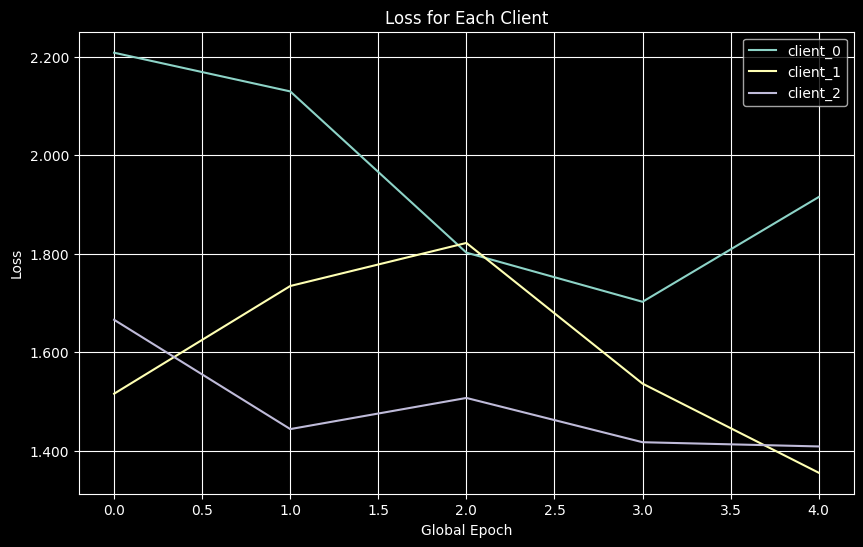

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_client_losses(folder_path):
    plt.figure(figsize=(10, 6))
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            client_name = os.path.splitext(file_name)[0]
            file_path = os.path.join(folder_path, file_name)
            
            # Read CSV file
            df = pd.read_csv(file_path)
            
            # Extract data
            global_epochs = df['Global Epoch']
            local_epochs = df['Local Epoch']
            index = df.index
            losses = df['Loss']

            # Plot
            plt.plot(index, losses, label=client_name)

    plt.title('Loss for Each Client')
    plt.xlabel('Global Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.ticklabel_format(axis='y', style='plain')  # Disable scientific notation
    plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))  # Format y-axis labels to 3 decimal places
    plt.show()

folder_path = "./ClientLoss"  # Change this to your folder path
plot_client_losses(folder_path)


In [9]:
import pandas as pd
df = pd.read_csv('./ClientLoss/client_0.csv')

In [11]:
df.columns

Index(['Global Epoch', 'Local Epoch', 'Loss'], dtype='object')